## 2. Unzip data 

In [ ]:
import zipfile
from pathlib import Path

zip_path = Path('data.zip')
extract_to = Path('data')

Path(extract_to).mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Extracted {zip_path} to {extract_to}')

Extracted data.zip to data


## 3. Configure training

In [ ]:
import yaml
from pathlib import Path

classes_txt = Path("data/classes.txt")
output_yaml = Path("data/data.yaml")

with open(classes_txt) as f:
    names = [line.strip() for line in f if line.strip()]

data = {
    "path": "data",
    "train": "train/images",
    "val": "validation/images",
    "nc": len(names),
    "names": names
}

output_yaml.parent.mkdir(parents=True, exist_ok=True)

with open(output_yaml, "w") as f:
    yaml.dump(data, f, sort_keys=False)

print("✅ data.yaml created at data/data.yaml")
print(data)

✅ data.yaml created at data/data.yaml
{'path': 'data', 'train': 'train/images', 'val': 'validation/images', 'nc': 6, 'names': ['OK_NoIssue', 'S1_AxisNotZero', 'S2_UnequalTickSpacing', 'S3_DistortedScaleRange', 'S4_MissingAxisValues', 'S5_MisusedDualAxis']}


# 4.Train model

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
0


In [ ]:

from ultralytics import YOLO
model = YOLO("yolov8n.pt")
# model.train(data="data/data.yaml", epochs=60, imgsz=640, batch=16, device=0) # Use device='cpu' if no GPU is available
model.train(data="data/data.yaml", epochs=60, imgsz=640, batch=16, device=0, name = 'ibcs_v2', exist_ok = True) # Use device='cpu' if no GPU is available

Ultralytics 8.3.240  Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ibcs_v2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000029C003E6690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

# 5. Test model 

I check if the data path match with the real folder data 

In [ ]:
from pathlib import Path

for p in [
    "data/train/images", "data/train/labels",
    "data/validation/images", "data/validation/labels"
]:
    path = Path(p)
    print(p, "exists=", path.exists(), "count=", len(list(path.glob("*")) ) if path.exists() else 0)


data/train/images exists= True count= 122
data/train/labels exists= True count= 122
data/validation/images exists= True count= 36
data/validation/labels exists= True count= 36


I check the dectection of models is good or not by counting total objects in labels

In [ ]:
from pathlib import Path

def count_objects(split):
    lbl_dir = Path(f"data/{split}/labels")
    total = 0
    for f in lbl_dir.glob("*.txt"):
        lines = [ln for ln in f.read_text().splitlines() if ln.strip()]
        total += len(lines)
    print(split, "total boxes:", total)

count_objects("train")
count_objects("validation")


train total boxes: 132
validation total boxes: 36


Sometimes the model predicts boxes but they get filtered out. So I test with lower confidence during inference (to see if predictions exist at all)

In [ ]:
from ultralytics import YOLO
from pathlib import Path

model = YOLO("runs/detect/ibcs_v2/weights/best.pt")  
results = model.predict("data/validation/images", conf=0.01, save=True)

print("Saved to:", results[0].save_dir)

# show how many boxes per image
for r in results[:10]:
    n = 0 if r.boxes is None else len(r.boxes)
    print(Path(r.path).name, "boxes:", n)



image 1/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\09f4c2f1-mMLbP.jpg: 384x640 5 OK_NoIssues, 2 S1_AxisNotZeros, 77.2ms
image 2/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\0f71c270-images.jpeg: 640x640 2 OK_NoIssues, 4 S1_AxisNotZeros, 84.4ms
image 3/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\26ef9e0b-screen-shot-2016-06-10-at-14-20-24.png: 640x640 2 OK_NoIssues, 11 S1_AxisNotZeros, 81.3ms
image 4/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\27917198-7a781a87-8c06-400f-a221-539c477a0362_528x302.png: 384x640 2 OK_NoIssues, 18.8ms
image 5/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\38f7a673-b7d316394613fd7033d363787cb5677a65719a3f_2_462x375.png: 544x640 7 OK_NoIssues, 1 S1_AxisNotZero, 47.6ms
image 6/

So we start seeing boxes at conf=0.01 but not at 0.25, your model is weak → needs more data/better training.

Now i test to see how well the model 


image 1/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\09f4c2f1-mMLbP.jpg: 384x640 1 OK_NoIssue, 33.5ms
image 2/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\0f71c270-images.jpeg: 640x640 1 OK_NoIssue, 6.0ms
image 3/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\26ef9e0b-screen-shot-2016-06-10-at-14-20-24.png: 640x640 1 OK_NoIssue, 1 S1_AxisNotZero, 6.0ms
image 4/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\27917198-7a781a87-8c06-400f-a221-539c477a0362_528x302.png: 384x640 1 OK_NoIssue, 11.1ms
image 5/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\38f7a673-b7d316394613fd7033d363787cb5677a65719a3f_2_462x375.png: 544x640 1 OK_NoIssue, 34.9ms
image 6/36 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\

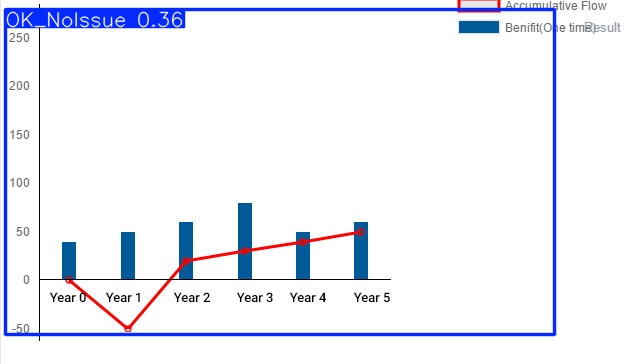

0f71c270-images.jpeg: OK_NoIssue (0.41) → ✅ COMPLIANT


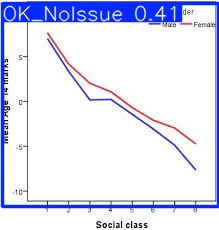

26ef9e0b-screen-shot-2016-06-10-at-14-20-24.png: OK_NoIssue (0.41) → ✅ COMPLIANT


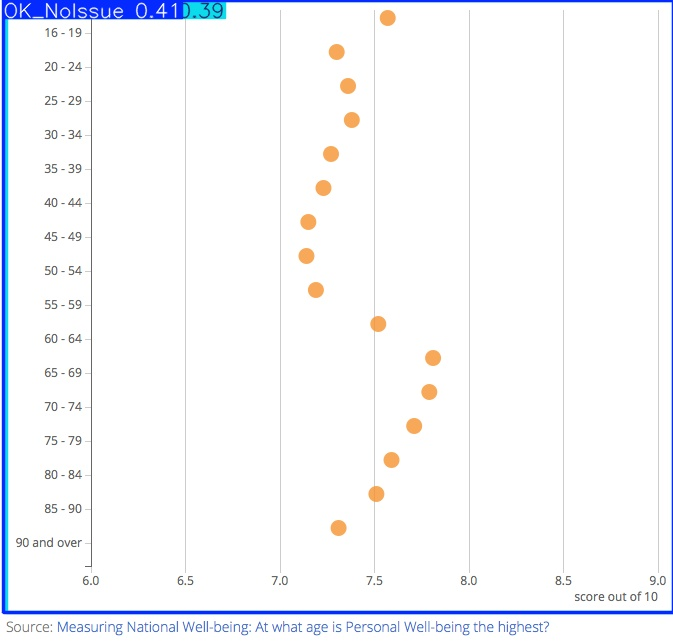

27917198-7a781a87-8c06-400f-a221-539c477a0362_528x302.png: OK_NoIssue (0.78) → ✅ COMPLIANT


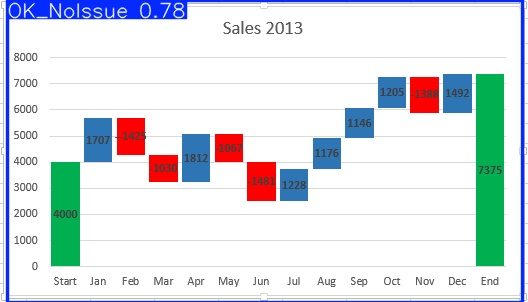

38f7a673-b7d316394613fd7033d363787cb5677a65719a3f_2_462x375.png: OK_NoIssue (0.77) → ✅ COMPLIANT


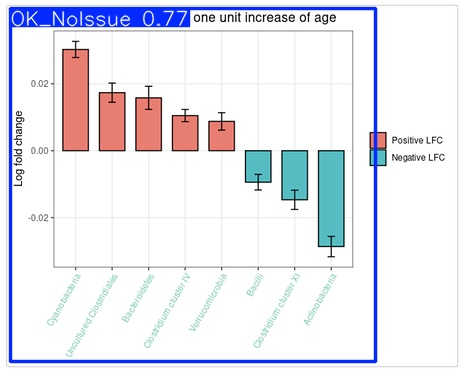

40e38777-unnamed-chunk-84-1.png: OK_NoIssue (0.59) → ✅ COMPLIANT


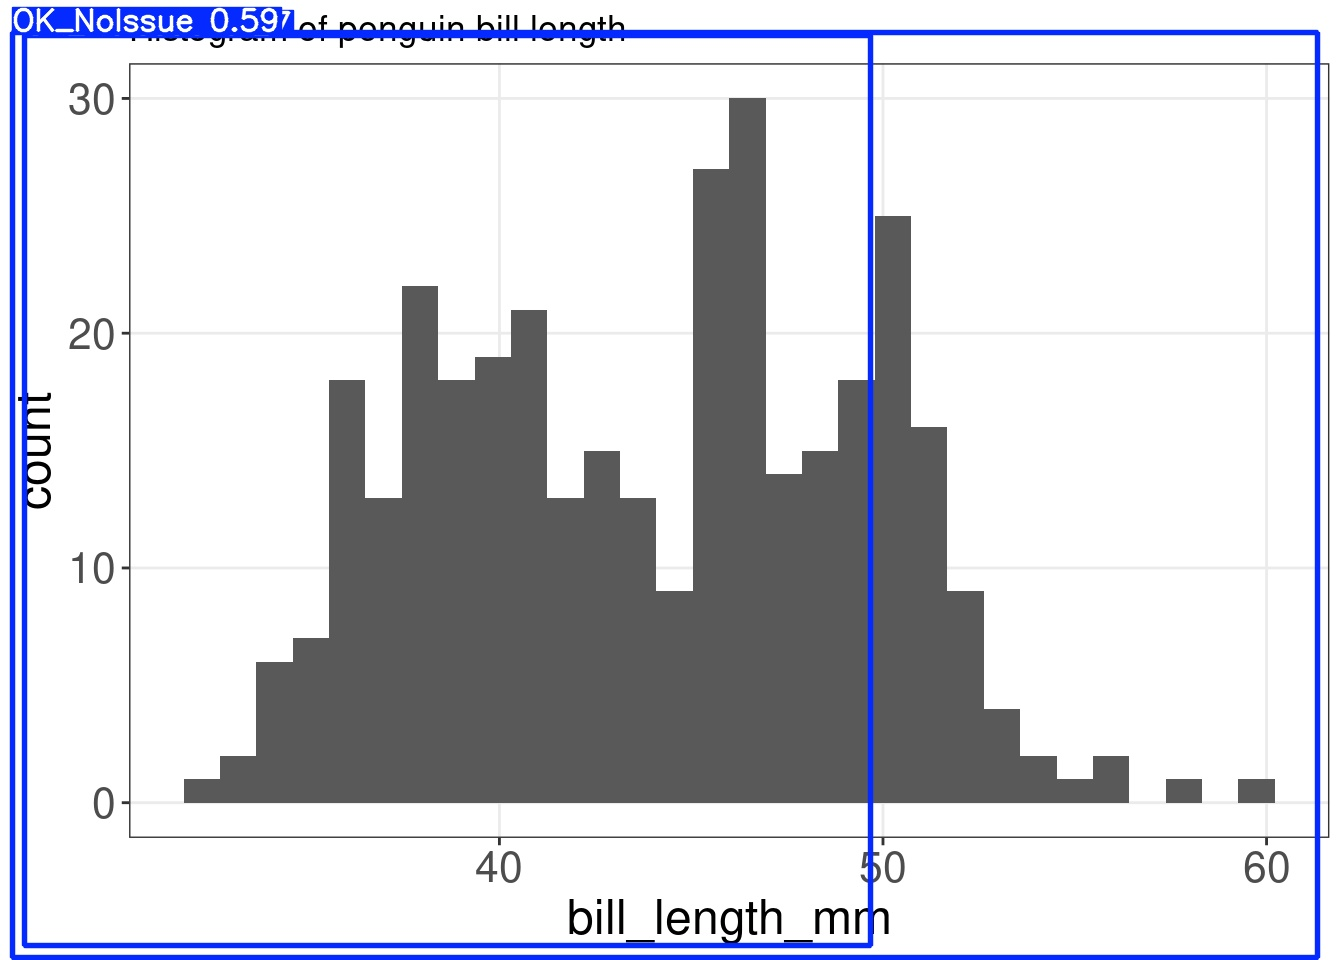

52914916-Screenshot_2025-12-20_200919.png: S1_AxisNotZero (0.79) → ❌ NON-COMPLIANT


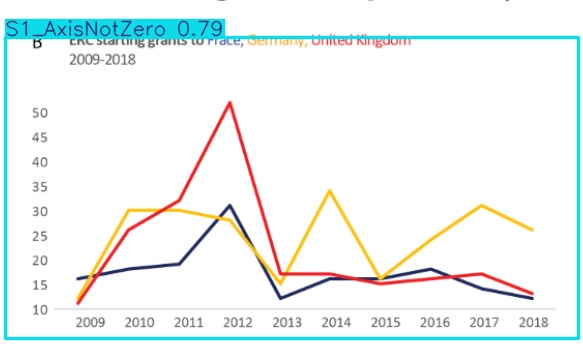

691d6be0-rule_34_lines_zero-03.webp: OK_NoIssue (0.56) → ✅ COMPLIANT


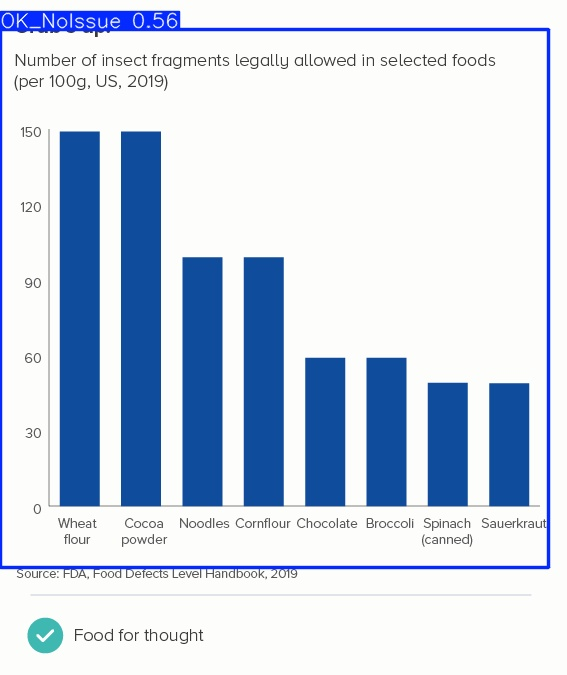

6ac315f2-sQMdX.png: S1_AxisNotZero (0.75) → ❌ NON-COMPLIANT


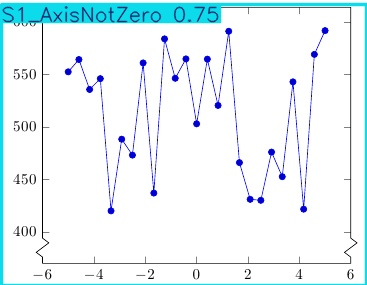

72273c2c-figure.png: S1_AxisNotZero (0.83) → ❌ NON-COMPLIANT


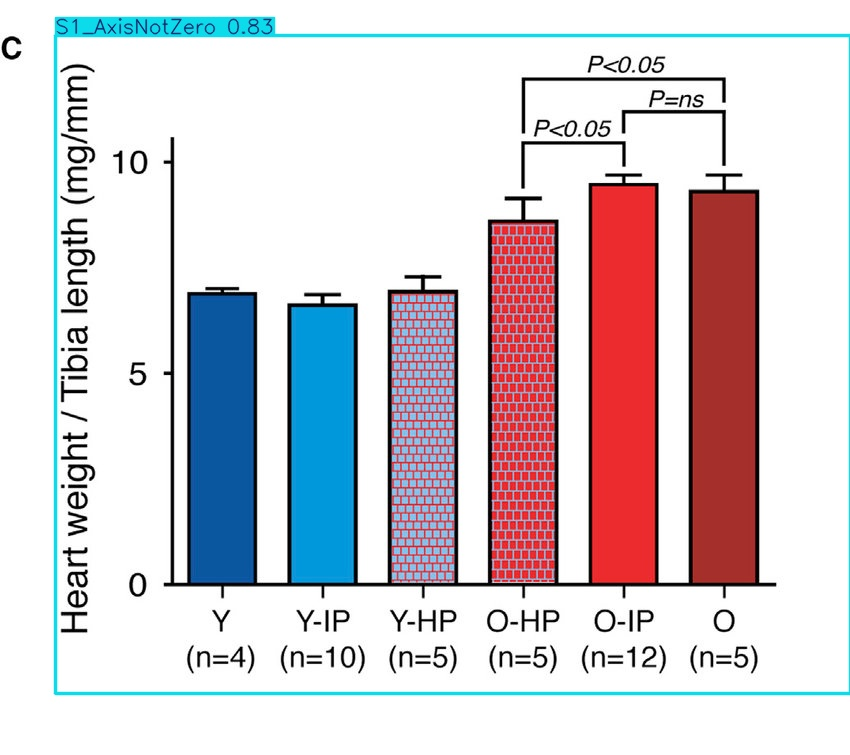

724d7e0b-k3DyT.jpg: OK_NoIssue (0.96) → ✅ COMPLIANT


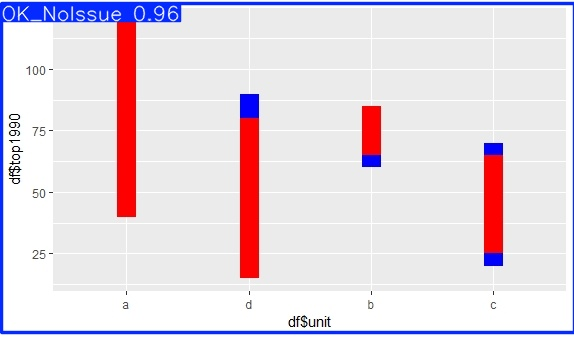

78bb0018-screen-shot-2016-06-17-at-11-22-39.png: OK_NoIssue (0.65) → ✅ COMPLIANT


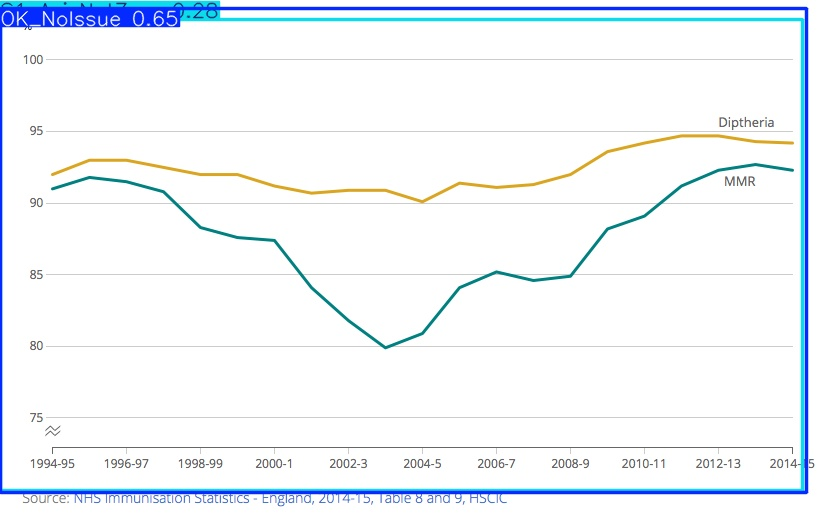

7c2a9fb9-rule_34_lines_zero-01.webp: S1_AxisNotZero (0.71) → ❌ NON-COMPLIANT


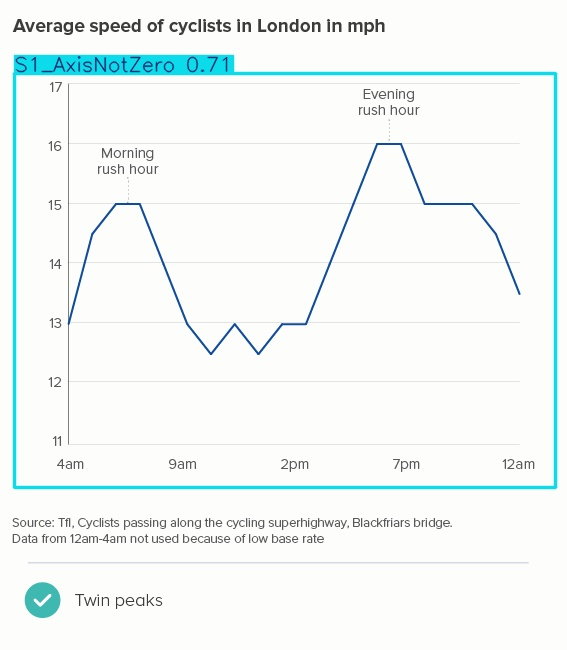

86e9e7c5-Screenshot_2025-12-20_200004.png: S1_AxisNotZero (0.74) → ❌ NON-COMPLIANT


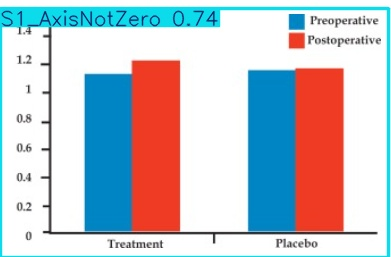

8ea9cca6-1XZUS.png: S1_AxisNotZero (0.65) → ❌ NON-COMPLIANT


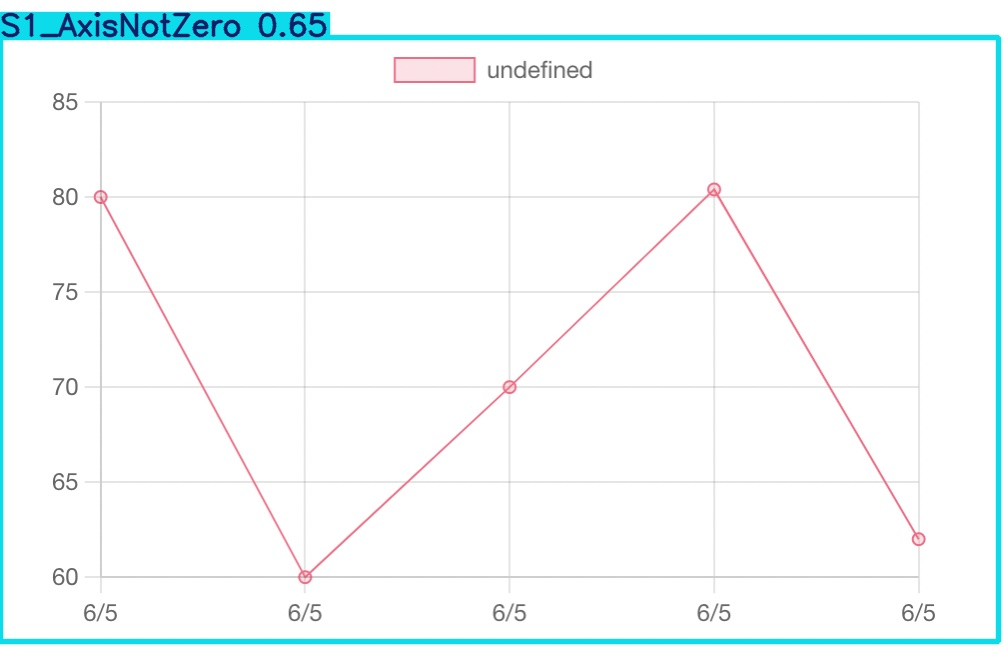

9bb2c0b6-BZ54g.png: OK_NoIssue (0.74) → ✅ COMPLIANT


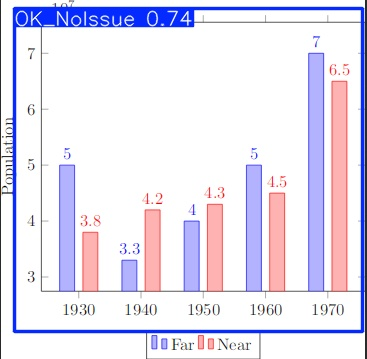

9bcc682a-17d562d3754d156294486dfae533e20d85850906.png: S1_AxisNotZero (0.63) → ❌ NON-COMPLIANT


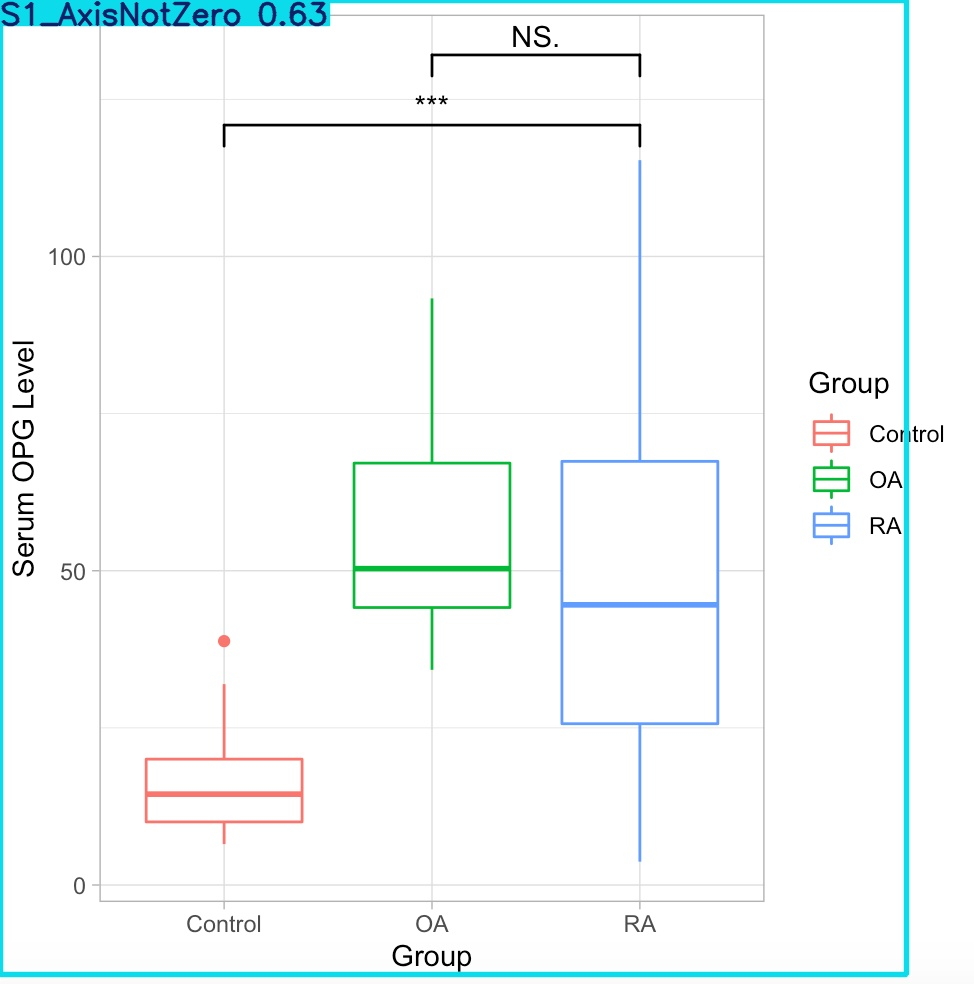

a107a204-54777_pastedImage_2.png: OK_NoIssue (0.35) → ✅ COMPLIANT


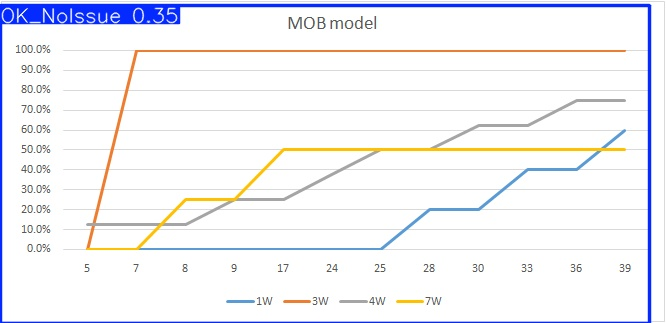

a308555c-cc-dome.webp: S1_AxisNotZero (0.58) → ❌ NON-COMPLIANT


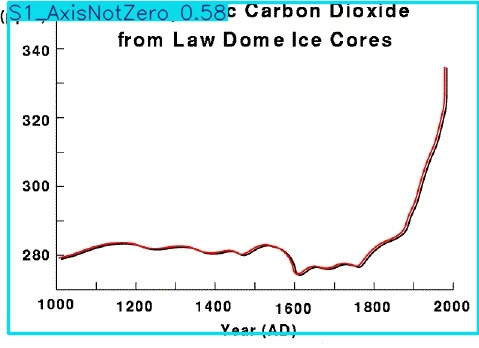

a64a8224-rule_34_lines_zero-11.webp: OK_NoIssue (0.81) → ✅ COMPLIANT


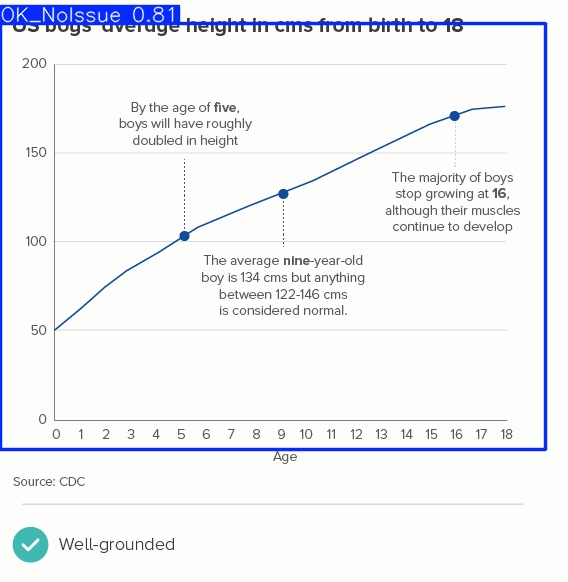

a69e29b2-sst.png: S1_AxisNotZero (0.64) → ❌ NON-COMPLIANT


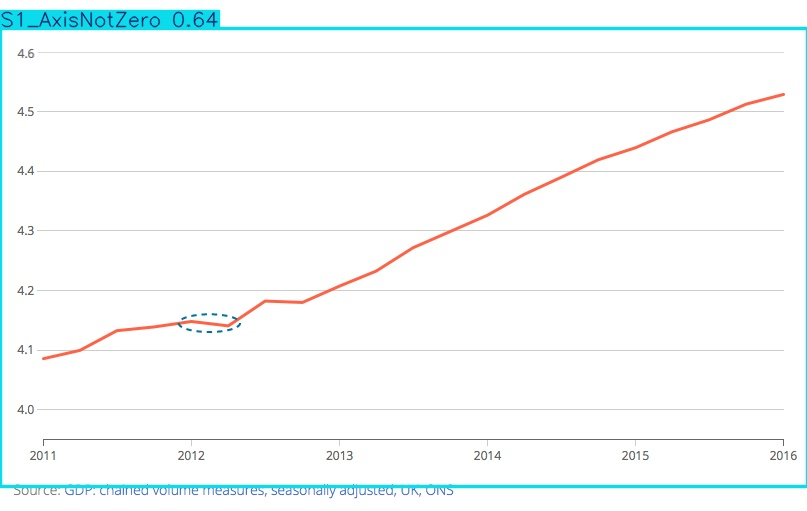

a7f05237-LineChart.png: OK_NoIssue (0.43) → ✅ COMPLIANT


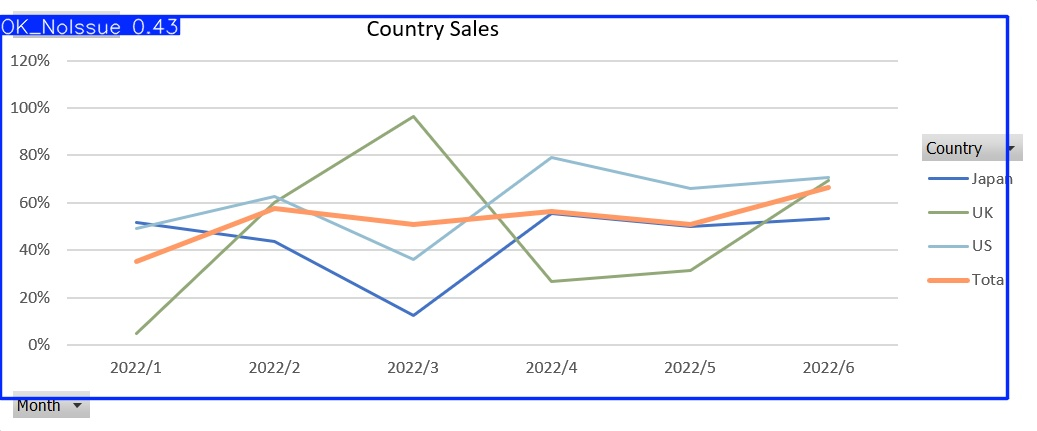

ad7a957c-3I6El.jpg: OK_NoIssue (0.72) → ✅ COMPLIANT


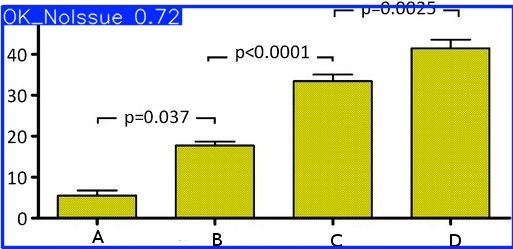

ae107112-59051728-dfeb0b00-888d-11e9-98ad-1aad572831c4.png: OK_NoIssue (0.59) → ✅ COMPLIANT


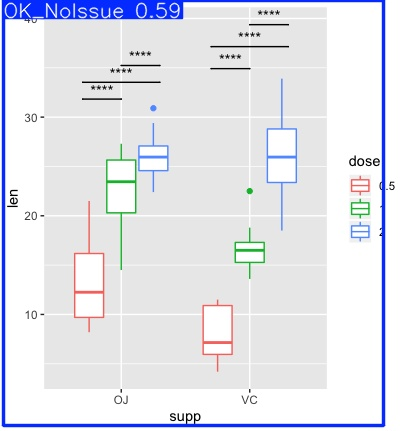

b33d4f4a-renditionDownloadd.jpeg: OK_NoIssue (0.80) → ✅ COMPLIANT


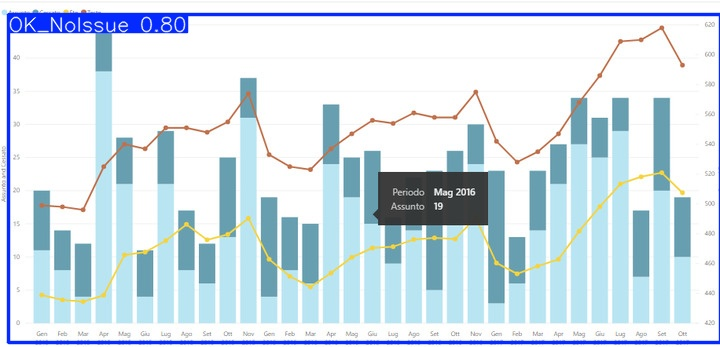

b613b6d4-mMLbP.jpg: OK_NoIssue (0.36) → ✅ COMPLIANT


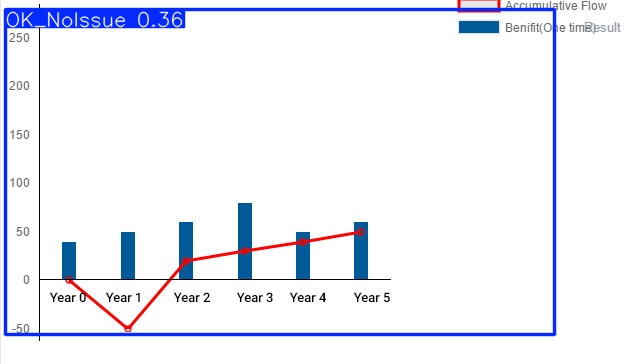

ca07eae9-Opal55_0-1616528223843.png: OK_NoIssue (0.35) → ✅ COMPLIANT


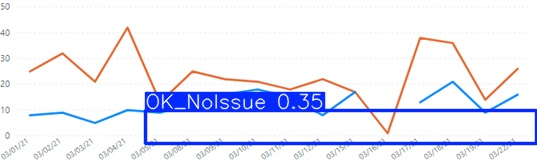

cb6f37e5-broken-column.png: OK_NoIssue (0.28) → ✅ COMPLIANT


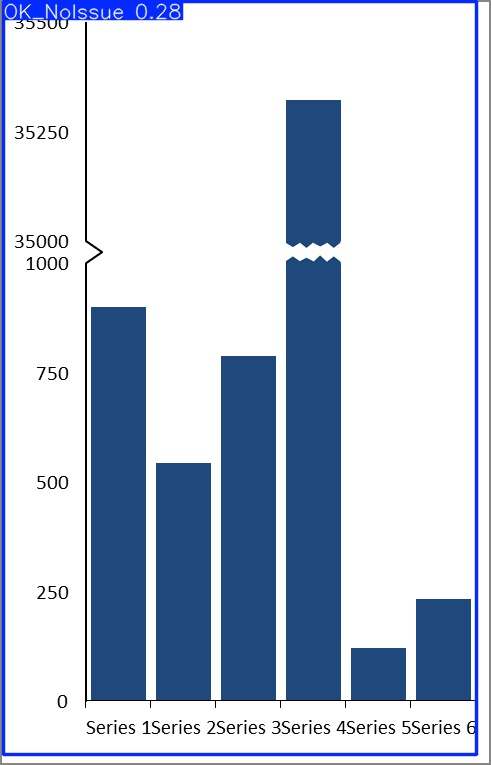

ced84051-41606_2024_107_Fig5_HTML.png: OK_NoIssue (0.80) → ✅ COMPLIANT


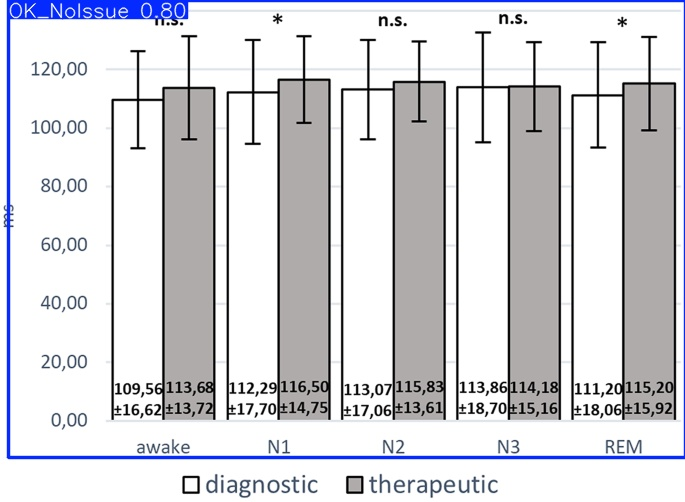

d5fa7a25-42925486-f6677e58-8b4b-11e8-9f3b-6ccb15a06823.png: S1_AxisNotZero (0.79) → ❌ NON-COMPLIANT


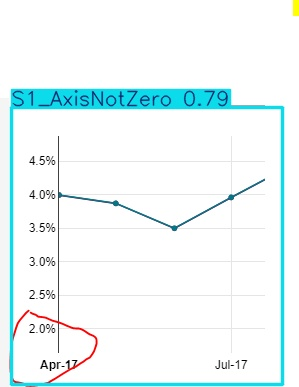

df7cac83-b7d316394613fd7033d363787cb5677a65719a3f_2_462x375.png: OK_NoIssue (0.77) → ✅ COMPLIANT


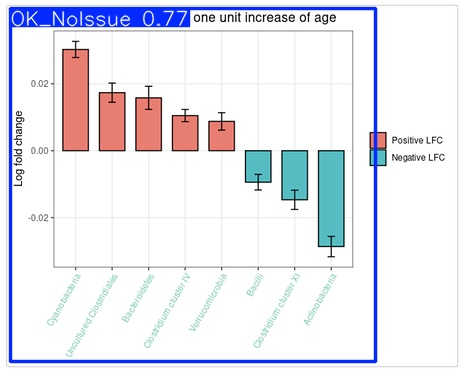

e1b7998e-PoojaDarbhe_0-1626777862868.png: S1_AxisNotZero (0.80) → ❌ NON-COMPLIANT


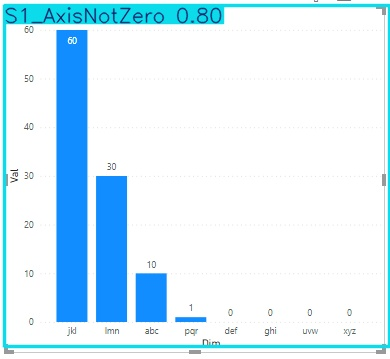

e23edfb8-accessible_color_contrast.png: S1_AxisNotZero (0.39) → ❌ NON-COMPLIANT


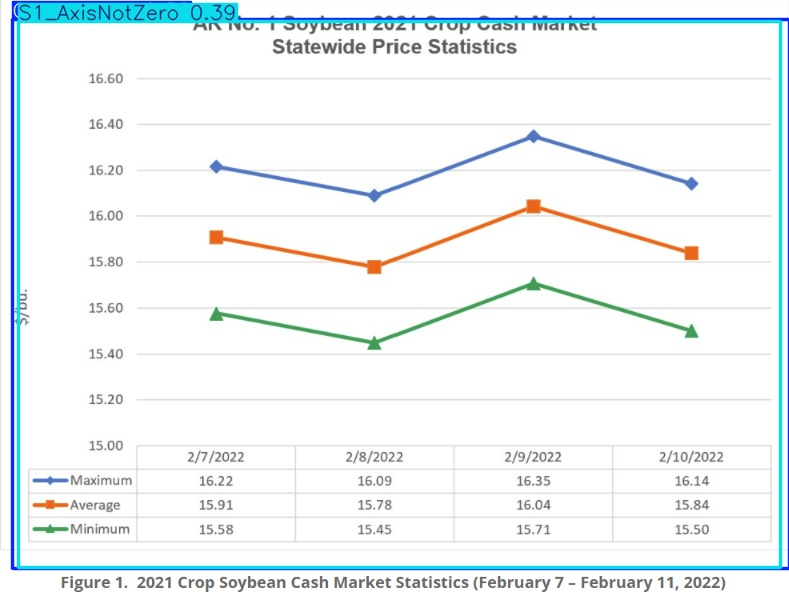

f5fba00b-renditionDown.jpeg: OK_NoIssue (0.91) → ✅ COMPLIANT


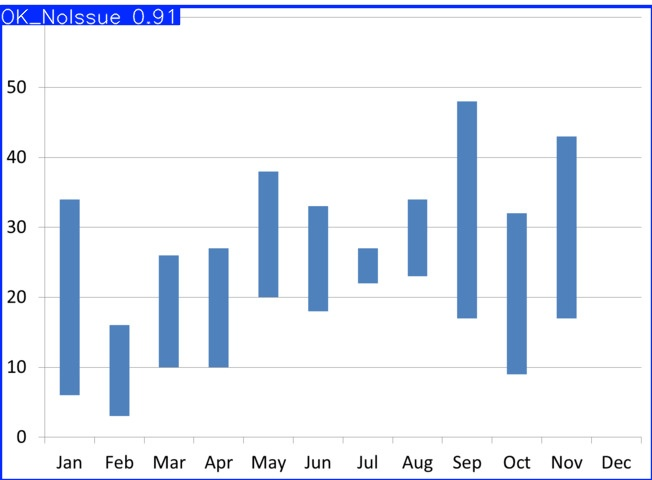

f8007ff9-60094329-08a74780-974c-11e9-8ee1-e6a97ddc338c.png: S1_AxisNotZero (0.41) → ❌ NON-COMPLIANT


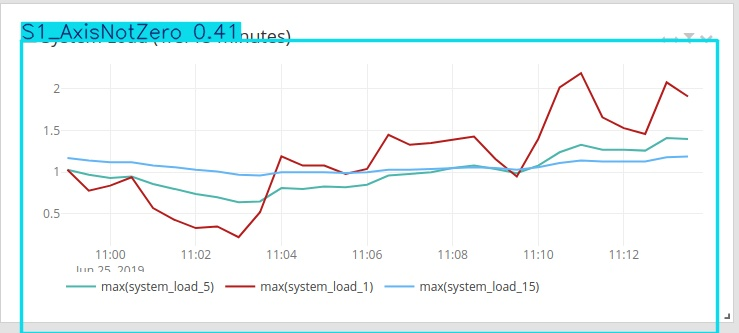

fd93020b-Figures_Page_13.jpg: OK_NoIssue (0.94) → ✅ COMPLIANT


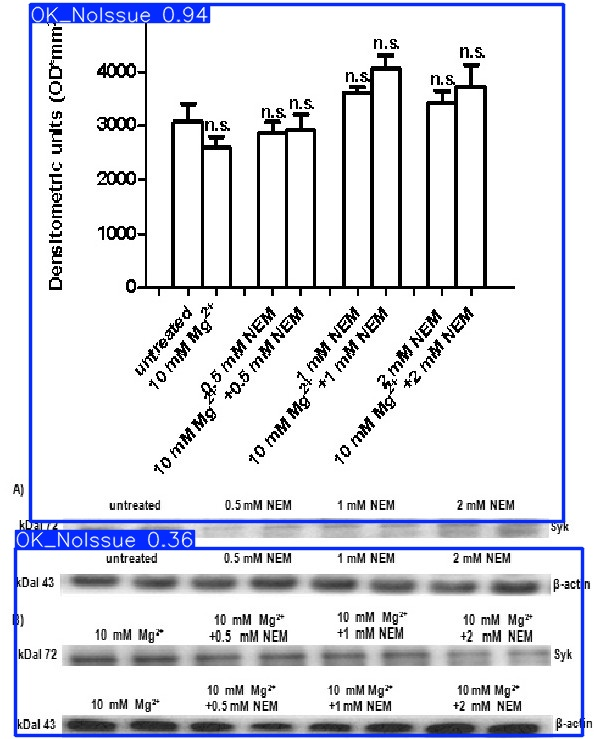

In [ ]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import os

CLASS_NAMES = [
    "OK_NoIssue",
    "S1_AxisNotZero",
    "S2_UnequalTickSpacing",
    "S3_DistortedScaleRange",
    "S4_MissingAxisValues",
    "S5_MisusedDualAxis"
]

# Load the trained model
model = YOLO("runs/detect/ibcs_v2/weights/best.pt")

# Predict + save annotated images
results = model.predict(
    source="data/validation/images",
    conf=0.25,
    save=True,
    device="gpu" if torch.cuda.is_available() else "cpu"
)

# The ACTUAL folder where YOLO saved images
save_dir = Path(results[0].save_dir)
print("✅ Predictions saved to:", save_dir)

# Loop through each prediction result
for r in results:
    image_name = Path(r.path).name

    # If no detection
    if r.boxes is None or len(r.boxes) == 0:
        print(f"{image_name}: ❌ No chart detected")
        # Still show original image (optional)
        display(Image(filename=str(r.path), height=350))
        continue

    # If you expect one chart per image, take the best-confidence box
    best_idx = int(r.boxes.conf.argmax().item())
    cls_id = int(r.boxes.cls[best_idx].item())
    cls_name = CLASS_NAMES[cls_id]

    compliance = "✅ COMPLIANT" if cls_name == "OK_NoIssue" else "❌ NON-COMPLIANT"
    conf = float(r.boxes.conf[best_idx].item())

    print(f"{image_name}: {cls_name} ({conf:.2f}) → {compliance}")

    # Show the annotated saved image (same filename as input)
    pred_img_path = save_dir / image_name
    if pred_img_path.exists():
        display(Image(filename=str(pred_img_path), height=350))
    else:
        # Sometimes Ultralytics saves as .jpg even if input was .png
        alt = pred_img_path.with_suffix(".jpg")
        if alt.exists():
            display(Image(filename=str(alt), height=350))
        else:
            print("⚠️ Annotated image not found, showing original instead.")
            display(Image(filename=str(r.path), height=350))


In [ ]:
# from ultralytics import YOLO

# model = YOLO("runs/detect/train5/weights/best.pt")
# results = model.predict(
#     source="data/validation/images",
#     save=True,
#     device='cpu'
# )

# print("Done! Check runs/detect/predict")


image 1/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\38f7a673-b7d316394613fd7033d363787cb5677a65719a3f_2_462x375.png: 544x640 (no detections), 98.8ms
image 2/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\691d6be0-rule_34_lines_zero-03.webp: 640x544 (no detections), 77.8ms
image 3/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\a64a8224-rule_34_lines_zero-11.webp: 640x640 (no detections), 72.4ms
image 4/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\f8007ff9-60094329-08a74780-974c-11e9-8ee1-e6a97ddc338c.png: 288x640 (no detections), 59.6ms
Speed: 5.3ms preprocess, 77.1ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)
Results saved to C:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\runs\detect\predict
Done! Check runs/detect/pr

Showing images from: C:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\runs\detect\predict7


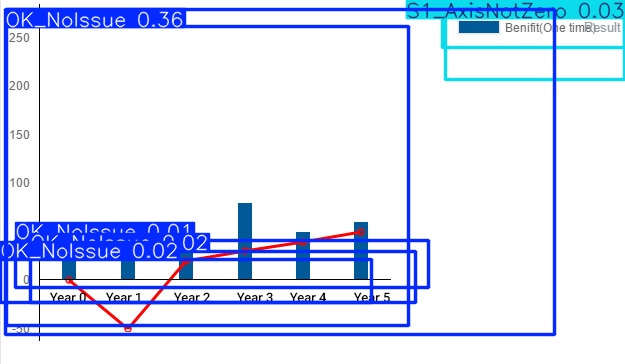

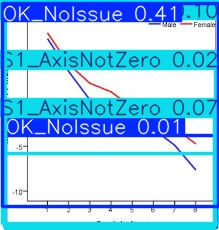

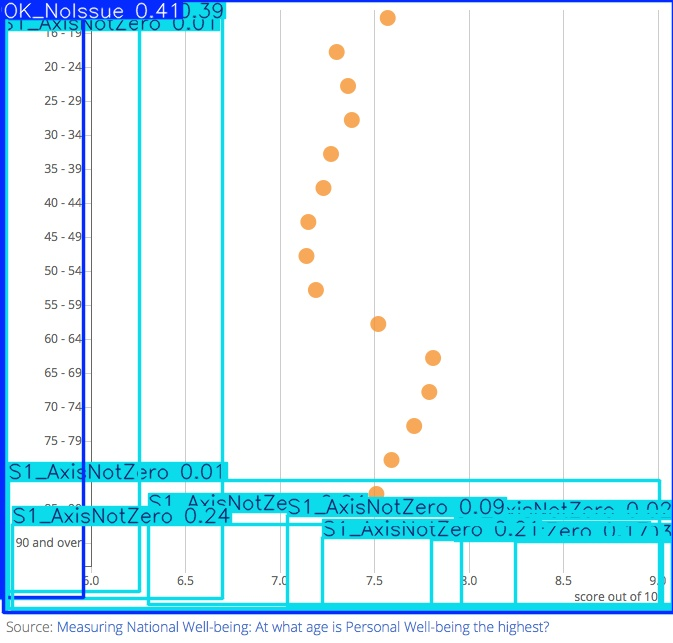

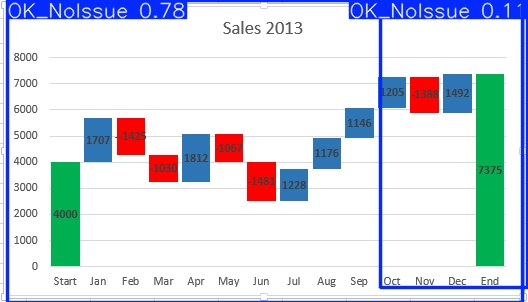

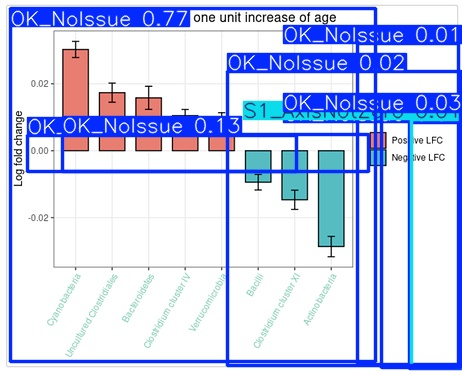

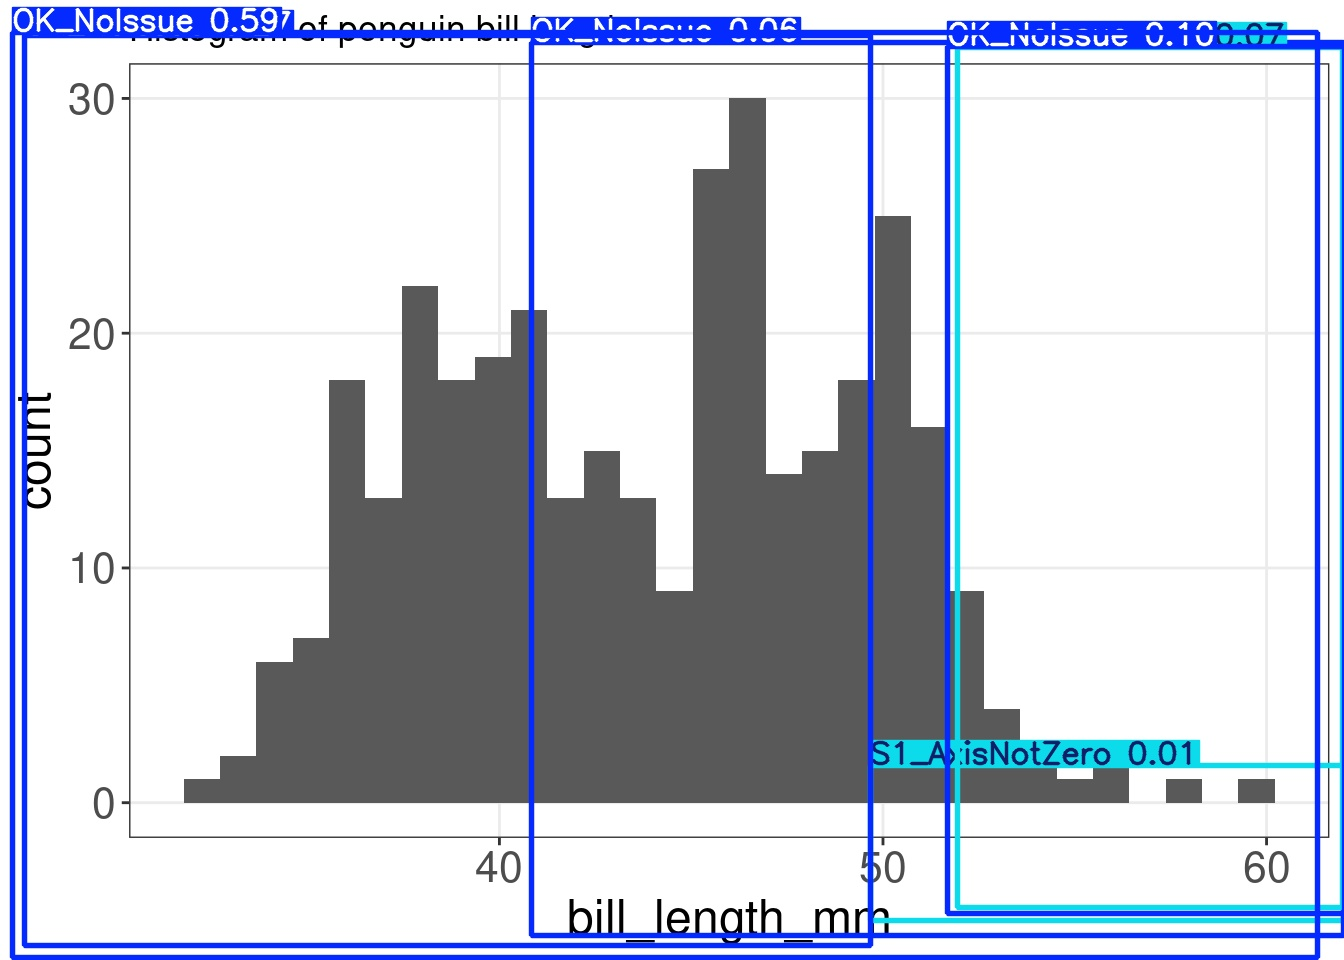

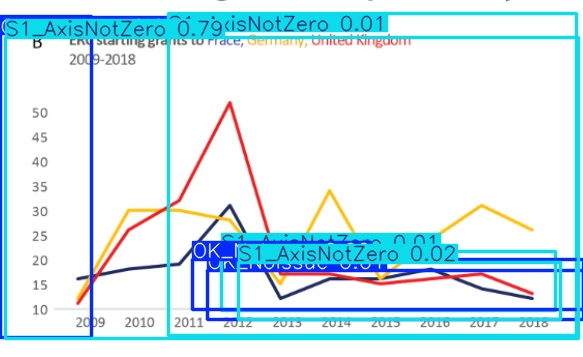

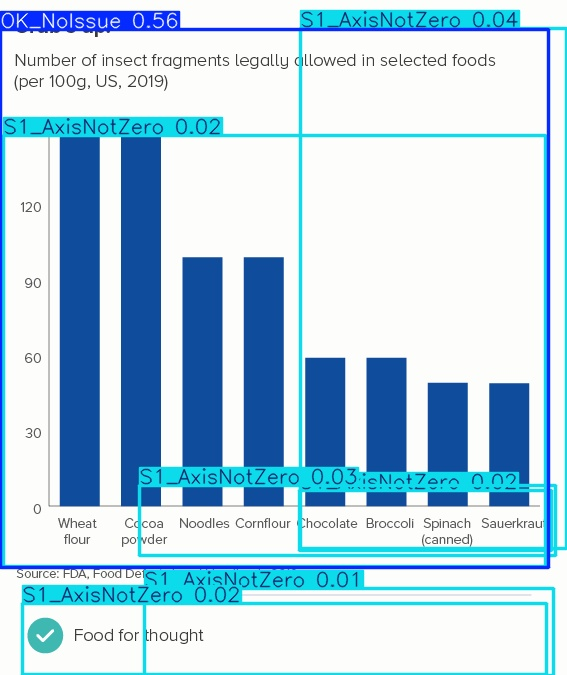

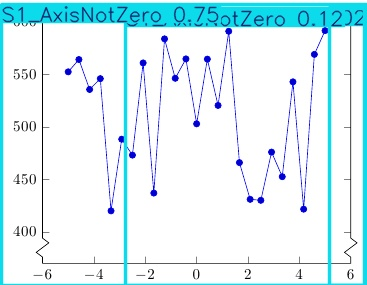

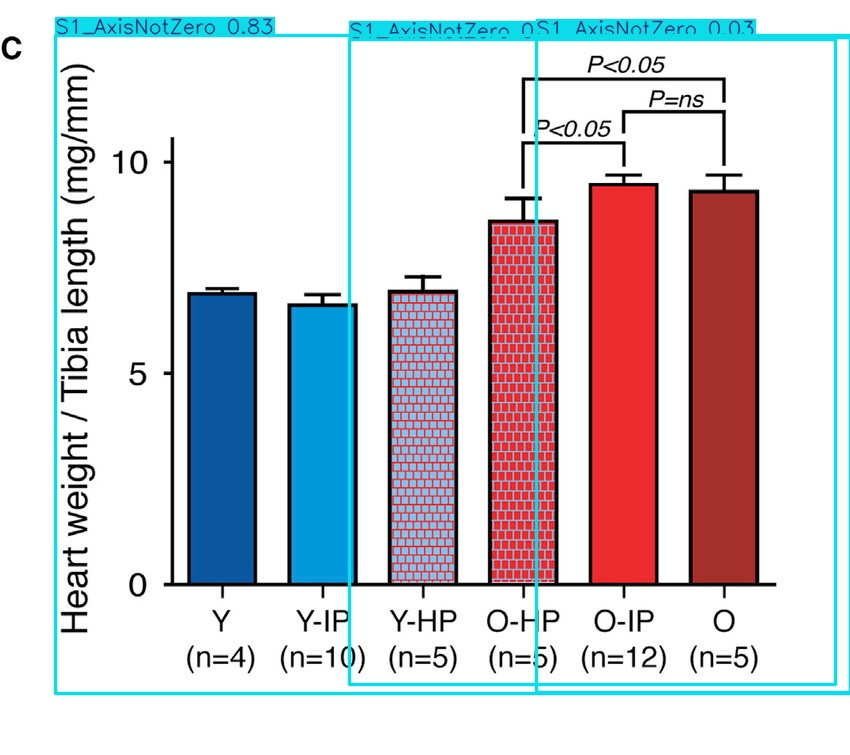

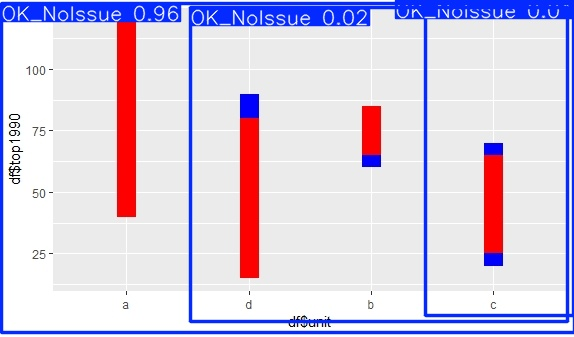

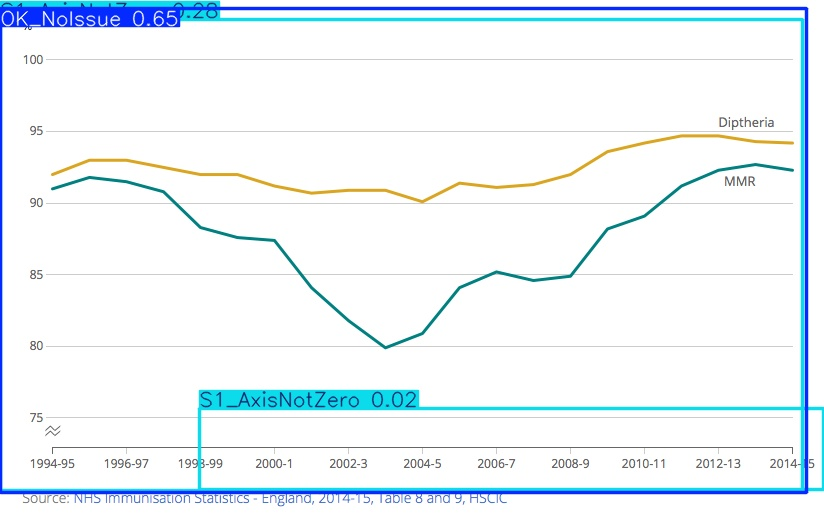

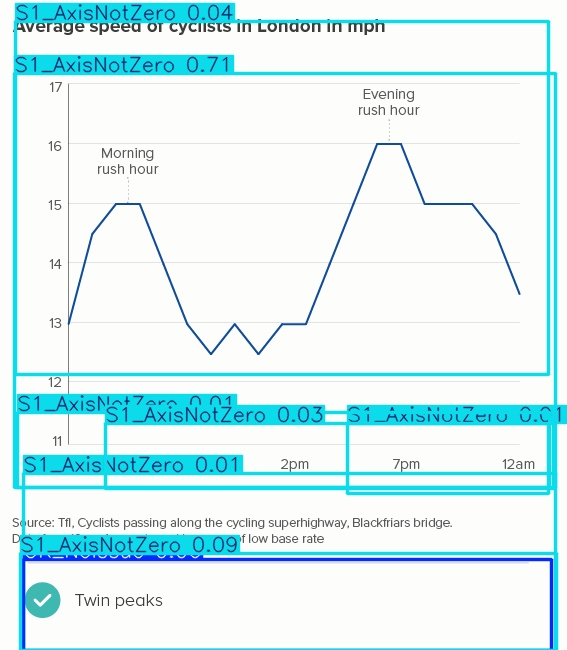

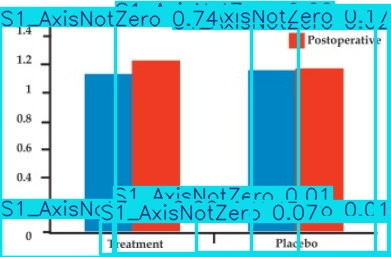

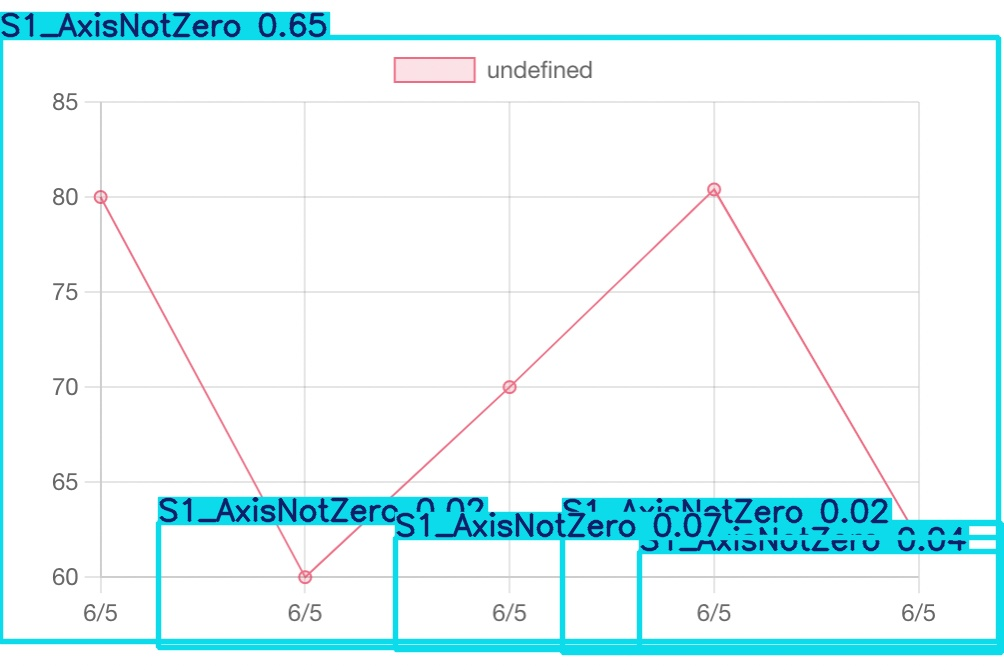

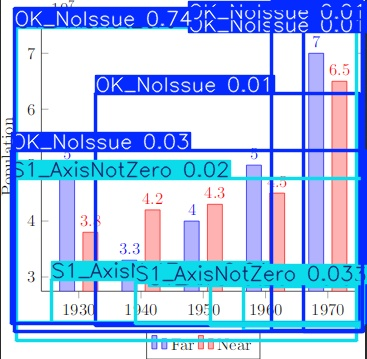

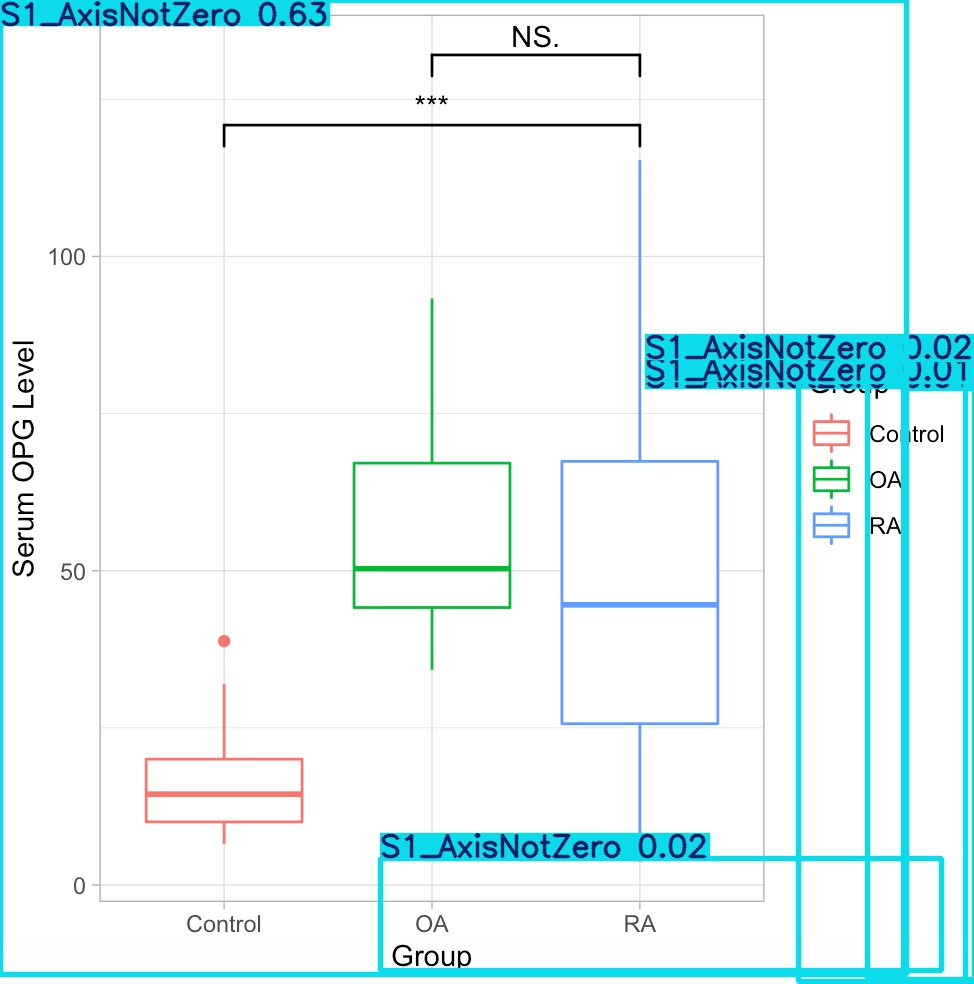

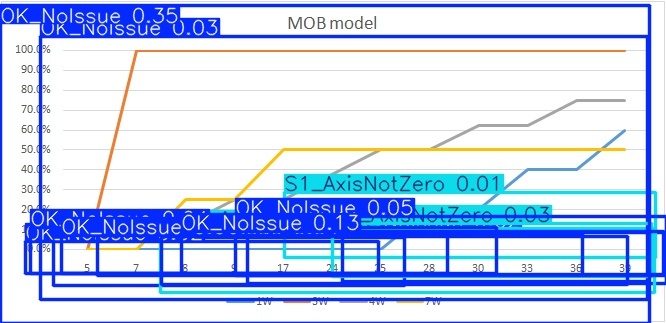

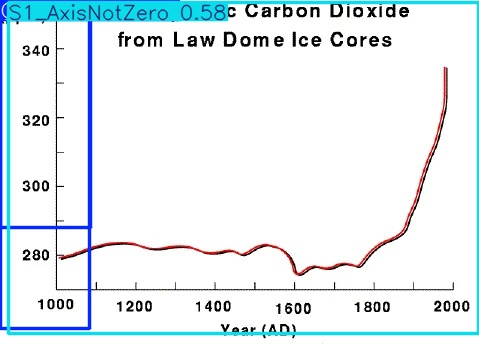

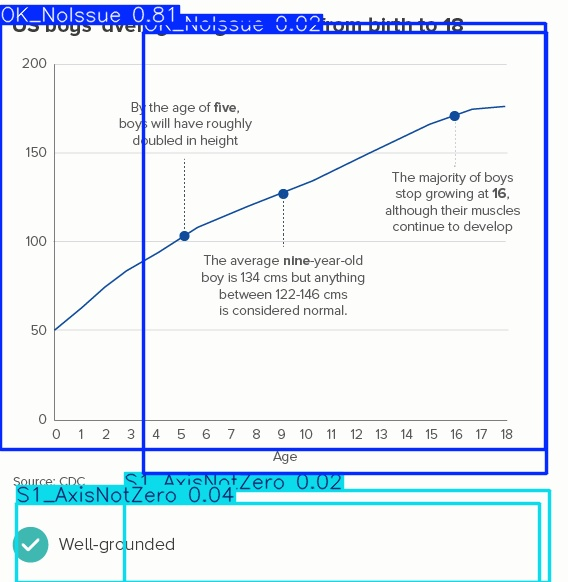

In [ ]:
import glob
from pathlib import Path
from IPython.display import Image, display

save_dir = Path(results[0].save_dir)  # the real output folder YOLO used
print("Showing images from:", save_dir)

for image_path in glob.glob(str(save_dir / "*.*"))[:20]:
    display(Image(filename=image_path, height=400))
    print("\n")
